This uses **band gap, density, energy per atom, formation energy per atom, volume, bulk modulus and shear modulus** data to predict the **density** of **Carbon.**

In [1]:
from pymatgen.ext.matproj import MPRester
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
API_KEY = "skJhy2zM0Gmz5S2q484qVitS2S27LqGv"

with MPRester(API_KEY) as mpr:
    results = mpr.materials.summary.search(
        elements=["C"],  
        fields=[
            "material_id", "formula_pretty", "band_gap", "density", "energy_per_atom",
            "formation_energy_per_atom", "volume", "bulk_modulus", "shear_modulus"
        ]
    )

data_list = [
    {
        "material_id": material.material_id,
        "formula_pretty": material.formula_pretty,
        "band_gap": material.band_gap,
        "density": material.density,
        "energy_per_atom": material.energy_per_atom,
        "formation_energy_per_atom": material.formation_energy_per_atom,
        "volume": material.volume,
        "bulk_modulus": material.bulk_modulus,
        "shear_modulus": material.shear_modulus
    }
    for material in results
]

df = pd.DataFrame(data_list)

df.head()

Retrieving SummaryDoc documents:   0%|          | 0/9030 [00:00<?, ?it/s]

,material_id,formula_pretty,band_gap,density,energy_per_atom,formation_energy_per_atom,volume,bulk_modulus,shear_modulus
0,mp-1197903,C,0.0797,1.030997,-7.818166,1.410500,1547.569425,None,None
1,mp-1244913,C,0.1060,1.675489,-8.234413,0.994253,1190.353192,None,None
2,mp-1244964,C,0.0724,1.769793,-8.294069,0.934597,1126.924923,None,None
3,mp-1245190,C,0.0000,1.783634,-8.213719,1.014946,1118.180174,None,None
4,mp-1182029,C,0.0000,1.377342,-8.226256,1.002409,115.841849,None,None


In [3]:
print(df.isnull().sum())

df = df.dropna()

print(df.isnull().sum())

material_id                     0
formula_pretty                  0
band_gap                        0
density                         0
energy_per_atom                 0
formation_energy_per_atom       0
volume                          0
bulk_modulus                 8596
shear_modulus                8596
dtype: int64
material_id                  0
formula_pretty               0
band_gap                     0
density                      0
energy_per_atom              0
formation_energy_per_atom    0
volume                       0
bulk_modulus                 0
shear_modulus                0
dtype: int64


In [4]:
features = ["band_gap", "energy_per_atom", "formation_energy_per_atom", "volume", "bulk_modulus", "shear_modulus"]
X = df[features]
y = df["density"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 347, Testing samples: 87


In [5]:
from sklearn.preprocessing import StandardScaler

print("Checking column data types before processing:\n")
print(df.dtypes)

for col in df.columns:
    first_value = df[col].iloc[0]
    if isinstance(first_value, dict):
        print(f"Column '{col}' contains dictionary data. Attempting to extract numeric values...")
        df[col] = df[col].apply(lambda x: x.get("value") if isinstance(x, dict) and "value" in x else None)

df_numeric = df.select_dtypes(include=["float64", "int64"]) 
print("\nColumns retained for training (numeric only):", df_numeric.columns)

X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop(columns=["density"]), df_numeric["density"], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nData Types After Processing:\n", df_numeric.dtypes)
print("\nFirst 5 Rows After Scaling:\n", X_train_scaled.head())


Checking column data types before processing:

material_id                   object
formula_pretty                object
band_gap                     float64
density                      float64
energy_per_atom              float64
formation_energy_per_atom    float64
volume                       float64
bulk_modulus                  object
shear_modulus                 object
dtype: object
Column 'bulk_modulus' contains dictionary data. Attempting to extract numeric values...
Column 'shear_modulus' contains dictionary data. Attempting to extract numeric values...

Columns retained for training (numeric only): Index(['band_gap', 'density', 'energy_per_atom', 'formation_energy_per_atom',
       'volume'],
      dtype='object')

Data Types After Processing:
 band_gap                     float64
density                      float64
energy_per_atom              float64
formation_energy_per_atom    float64
volume                       float64
dtype: object

First 5 Rows After Scaling:
    b

In [8]:
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Original feature count: {X_train.shape[1]}, New feature count: {X_train_poly.shape[1]}")

Original feature count: 4, New feature count: 15


In [9]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 8.2369
Mean Absolute Error (MAE): 2.2279
Root Mean Squared Error (RMSE): 2.8700
R² Score: 0.4582


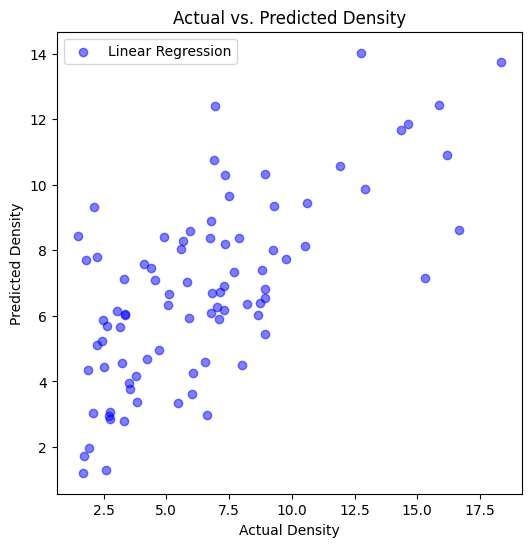

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue", label="Linear Regression")
plt.xlabel("Actual Density")
plt.ylabel("Predicted Density")
plt.title("Actual vs. Predicted Density")
plt.legend()
plt.show()
